In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

2024-03-31 11:14:19.515027: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 11:14:19.515162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 11:14:19.650113: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_path = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_path = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Visualising 

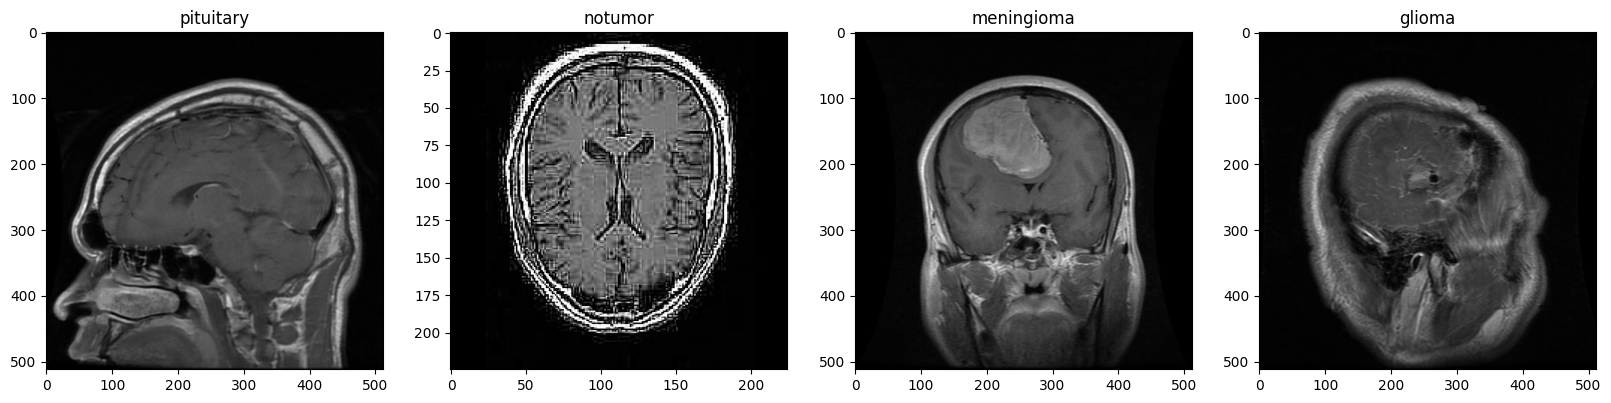

In [3]:
k=0
plt.figure(figsize=(20, 20))
for i in os.listdir(train_path):
    for img_path in os.listdir(os.path.join(train_path, i))[:1]:
        plt.subplot(1, 4, k + 1)
        img = cv2.imread(os.path.join(train_path, i, img_path))
        plt.imshow(img)
        plt.title(i)
        k += 1
plt.show()

# Creating datagens

In [4]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    rescale=1/255.0
)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0
)

In [5]:
train_set = train_gen.flow_from_directory(
    train_path, 
    target_size=(256, 256),
    color_mode = 'grayscale',
    subset = 'training'
)
valid_set = train_data = train_gen.flow_from_directory(
    train_path, 
    target_size=(256, 256),
    color_mode = 'grayscale',
    subset = 'validation'
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [6]:
test_set = test_gen.flow_from_directory(
    test_path, 
    target_size=(256, 256),
    color_mode = 'grayscale',
)

Found 1311 images belonging to 4 classes.


# Building Model

In [7]:
img_shape = (256, 256, 1)
model = tf.keras.Sequential([
    Input(shape=img_shape),
    
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    Dense(512, activation="relu"),
    Dense(4, activation="softmax")
])

model.compile (
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=["accuracy"]
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 252, 252, 64)   │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 84, 84, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 23, 23, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,548,740 (5.91 MB)

 Trainable params: 1,548,740 (5.91 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
early_stop = tf.keras.callbacks.EarlyStopping(
    patience = 10,
    monitor = 'val_loss'
)

In [9]:
EPOCHS = 100
history = model.fit(
    train_set,
    validation_data = valid_set,
    epochs = EPOCHS,
    callbacks = [early_stop]
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/143 ━━━━━━━━━━━━━━━━━━━━ 26:09 11s/step - accuracy: 0.1875 - loss: 1.3856

I0000 00:00:1711883687.121210      96 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711883687.139529      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.4315 - loss: 1.1382

W0000 00:00:1711883727.584199      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


143/143 ━━━━━━━━━━━━━━━━━━━━ 62s 358ms/step - accuracy: 0.4332 - loss: 1.1358 - val_accuracy: 0.6503 - val_loss: 0.8695
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 210ms/step - accuracy: 0.7093 - loss: 0.7130 - val_accuracy: 0.7152 - val_loss: 0.8698
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 215ms/step - accuracy: 0.7859 - loss: 0.5466 - val_accuracy: 0.7555 - val_loss: 0.6702
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 211ms/step - accuracy: 0.8372 - loss: 0.4364 - val_accuracy: 0.7940 - val_loss: 0.6000
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 214ms/step - accuracy: 0.8573 - loss: 0.3733 - val_accuracy: 0.7686 - val_loss: 0.6966
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 214ms/step - accuracy: 0.8941 - loss: 0.2973 - val_accuracy: 0.8203 - val_loss: 0.5837
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 215ms/step - accuracy: 0.9014 - loss: 0.2677 - val_accuracy: 0.8291 - val_loss: 0.5151
Epoch 8/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 215ms/step - accuracy: 0.9141 - loss: 0.213

# Evaluating

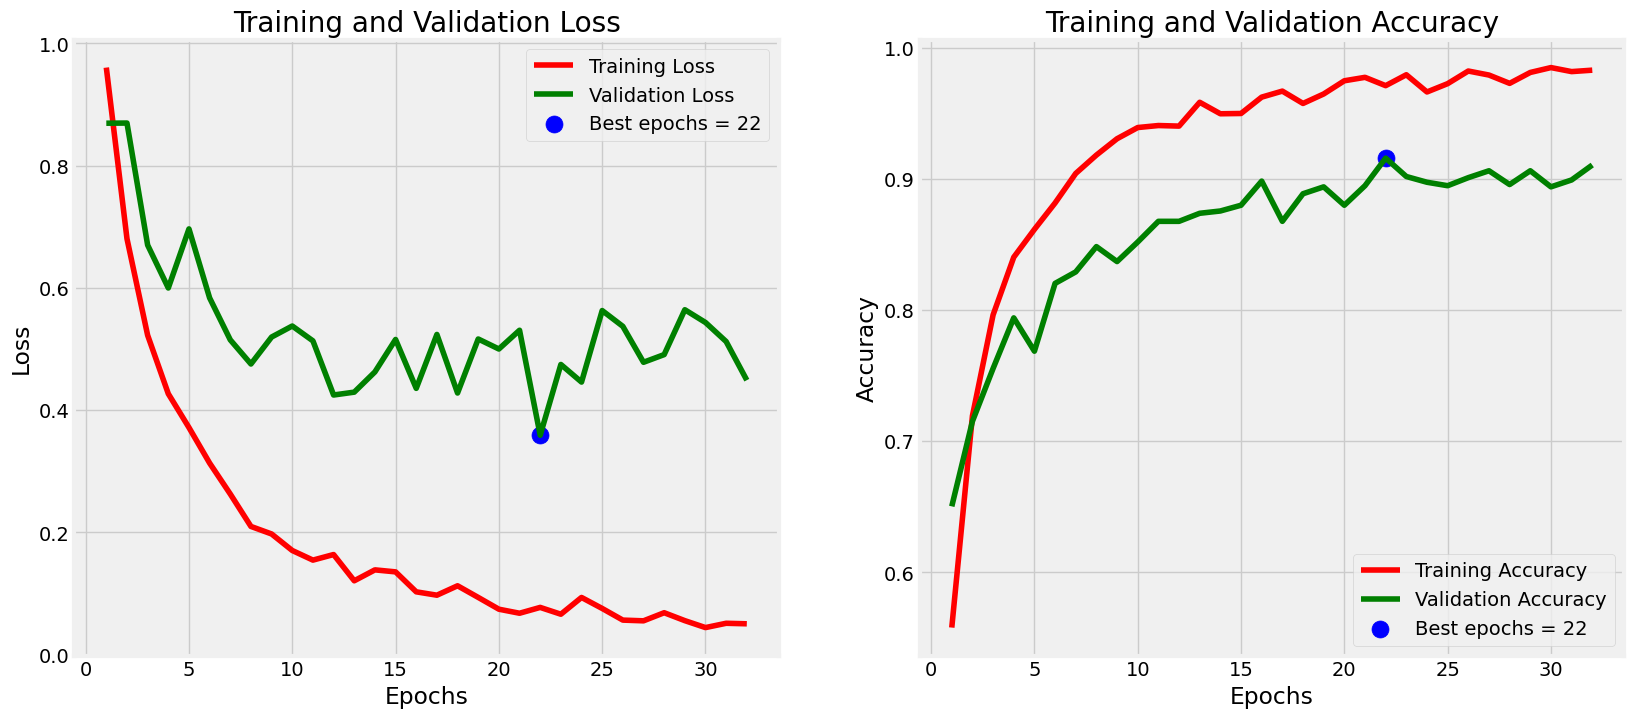

In [10]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()